In [ ]:
# This script will compare buy & sells of a given stock relative to the price action, 
# It is designed to analyze when I bought & sold a stock (Daytrading) vs the price action. 
# April 2025

In [207]:
import pandas as pd
import plotnine as p9
import yfinance as yf
from datetime import datetime, timedelta


In [231]:

def filter_time_window(data, universal_time_col='Datetime', filtering_time_col="FilledTime", units = "m",time_buffer=10):
    """
    Filter the data to include rows within a time interval of +/- time_buffer_minutes.

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing a time column.
    - time_column (str): The name of the time column in the DataFrame.
    - time_buffer_minutes (int): The number of minutes to extend the time range.

    Returns:
    - pd.DataFrame: A filtered DataFrame within the specified time interval.
    """
    min_time = data[filtering_time_col].min() - pd.Timedelta(time_buffer,unit=units)
    max_time = data[filtering_time_col].max() + pd.Timedelta(time_buffer,unit=units)
    return data[(data[universal_time_col] >= min_time) & (data[universal_time_col] <= max_time)]


def format_orders(df):
    """
    Format the stock orders DataFrame by converting date columns to datetime and renaming columns.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing stock order records.
    
    Returns:
    - pd.DataFrame: The formatted DataFrame with renamed columns and datetime conversions.
    """
    #df.rename(columns={'Placed Time': 'PlacedTime', 'Symbol': 'Symbol', 'Side': 'Side', 'Avg Price': 'Avg Price'})
    df['Placed Time'] = pd.to_datetime(df['Placed Time'].str.replace(" EDT",""), format="%m/%d/%Y %H:%M:%S").dt.tz_localize('America/New_York')
    df['Filled Time'] = pd.to_datetime(df['Filled Time'].str.replace(" EDT",""), format="%m/%d/%Y %H:%M:%S").dt.tz_localize('America/New_York')

    df['Date'] = df['Placed Time'].dt.date
    df['Time'] = df['Placed Time'].dt.time    

    df['key_placed'] = df['Symbol'].astype(str) + "_" + df['Placed Time'].astype(str)
    
    df.rename(columns={'Order ID': 'OrderID', 'Symbol': 'Symbol', 'Side': 'Side', 'Avg Price': 'AvgPrice', 
                       'Quantity': 'Quantity', 'Status': 'Status', 'Placed Time': 'PlacedTime', 
                       'Filled Time': 'FilledTime'}, inplace=True)
    

    # Filter rows where the 'status' column is 'Filled'
    #filled_orders['FilledTime_dt']=pd.to_datetime(filled_orders['Filled Time'].str.replace(" EDT",""), format="%m/%d/%Y %H:%M:%S")
    #filled_orders['FilledTime_dt_ny'] = filled_orders['FilledTime_dt'].dt.tz_localize('America/New_York')
    #filled_orders.pivot(index=['Symbol', 'Placed Time'], columns='Side', values='Avg Price').reset_index()

    return df


def filter_stock_orders(df, cutoff_date=None,days=10):
    """
    Filter the stock orders DataFrame to include only filled orders within a specific time window.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing stock order records.
    
    Returns:
    - pd.DataFrame: The filtered DataFrame with filled orders within the specified time window.
    """

    if cutoff_date is None:
        cutoff_date = datetime.now() - timedelta(days=days)
        cutoff_date = pd.to_datetime(cutoff_date,format="%m/%d/%Y %H:%M:%S").tz_localize('America/New_York')
    
    # Filter the DataFrame for filled orders within the specified time window
    filtered_df = df[df['FilledTime'] > cutoff_date]
    
    return filtered_df

def pair_buy_sell(filled_orders_filtered):
    filled_orders_wide = filled_orders_filtered.pivot(index=['Symbol', 'PlacedTime'], columns='Side', values='AvgPrice').reset_index()
    filled_orders_wide.sort_values(by=['Symbol', 'PlacedTime'], inplace=True)

    # Forward fill 'Buy' and backward fill 'Sell' to pair sequential times
    filled_orders_wide['Buy_Time_MM']=filled_orders_wide['Buy'].isna()
    filled_orders_wide['Sell_Time_MM']=filled_orders_wide['Sell'].isna()
    filled_orders_wide['Buy'] = filled_orders_wide['Buy'].fillna(method='ffill')
    filled_orders_wide['Sell'] = filled_orders_wide['Sell'].fillna(method='bfill')
    filled_orders_wide['key_placed'] = filled_orders_wide['Symbol'].astype(str) + "_" + filled_orders_wide['PlacedTime'].astype(str)

    filled_orders_wide.drop(columns=['Symbol','PlacedTime'], inplace=True)

    return filled_orders_wide


def compute_stats(df):

    df['Gain_per_share'] = df['Sell'] - df['Buy']
    df['Gain_total'] = df['Gain_per_share'] * df['Filled']
    df['Success'] = df['Gain_total'] > 0

    return df



def compute_summary(df):

    # Compute daily accuracy
    daily_success = df.groupby('Date')['Success'].sum().reset_index(name='Daily_success')
    total_trades = df.groupby('Date')['Success'].count().reset_index(name='Total_trades')
    daily_accuracy = df.groupby('Date').apply(lambda x: x['Success'].sum() / len(x)).reset_index(name='Daily_accuracy')

    daily_accuracy_detailed = daily_accuracy.merge(daily_success, on='Date').merge(total_trades, on='Date')

    # Compute daily total gain
    daily_total_gain = df.groupby('Date')['Gain_total'].sum().reset_index(name='Daily_total_gain')

    # Compute daily average gain
    daily_avg_gain = df.groupby('Date')['Gain_total'].mean().reset_index(name='Daily_avg_gain')

    # Merge all summaries into a single DataFrame
    daily_summary = daily_accuracy_detailed.merge(daily_total_gain, on='Date').merge(daily_avg_gain, on='Date')


    # compute overalls: 
    overall_accuracy = df['Success'].sum() / len(df['Success'])
    overall_total_gain = df['Gain_total'].sum()
    overall_avg_gain = df['Gain_total'].mean()
    overall_summary = pd.DataFrame({
        'Overall_accuracy': [overall_accuracy],
        'Overall_total_gain': [overall_total_gain],
        'Overall_avg_gain': [overall_avg_gain]
    })


    return {'daily_summary': daily_summary,'overall_summary': overall_summary}




Load Webull
* Load raw data
* Filter: 
    * Filled
    * Optional : date 
* Format data:
    * Convert to datetime
    * Get date only
    * Get time only
* Pair buy & sell 
* Compute stats

In [ ]:
# Load the stock orders file
stock_order_records = pd.read_csv("~/Downloads/Webull_Orders_Records.csv")

stock_orders_formatted = format_orders(stock_order_records)
filled_orders = stock_orders_formatted[stock_orders_formatted['Status'] == 'Filled']
filled_orders_filtered = filter_stock_orders(filled_orders,days=10000)

filled_orders_filtered

paired_buy_sell = pair_buy_sell(filled_orders_filtered)
paired_buy_sell_filtered = paired_buy_sell[~paired_buy_sell['Sell_Time_MM']]
filled_orders_filtered_subcols = filled_orders_filtered[['key_placed','Symbol','Filled','Date','Time']]
filled_orders_filtered_wide = pd.merge(filled_orders_filtered_subcols.drop_duplicates(),paired_buy_sell_filtered) 
filled_orders_filtered_wide


filled_orders_w_stats = compute_stats(filled_orders_filtered_wide)

compute_summary(filled_orders_w_stats)

## STOPPED HERE



# 
#display(filled_orders_filtered_subcols)
#display(paired_buy_sell_filtered)
# filled_orders_sub=filled_orders[['key_placed','Symbol','FilledTime_dt_ny','Filled','Total_Price','Date']]#.to_csv(f"filled_orders_{start_date}.tsv", index=False,sep="\t")

# filled_orders_time_align["Success"] = filled_orders_time_align['Total_Price']>0
# filled_orders_time_align_summary = filled_orders_time_align.groupby("Date").agg({"Success":"sum","Total_Price":"sum","Buy":"count"}).reset_index()#.to_csv(f"filled_orders_summary_{start_date}.tsv", index=False,sep="\t")
# filled_orders_time_align_summary['Accuracy'] = filled_orders_time_align_summary['Success'] / filled_orders_time_align_summary['Buy']
# filled_orders_time_align_summary

# Convert to long and pair up buys and sells

/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/1355753090.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/1355753090.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/1611451805.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


{'daily_summary':           Date  Daily_accuracy  Daily_success  Total_trades  Daily_total_gain  \
 0   2025-04-21        1.000000              1             1              0.10   
 1   2025-04-22        0.500000              1             2             -0.14   
 2   2025-04-23        0.750000              3             4              1.04   
 3   2025-04-24        0.400000              2             5              0.36   
 4   2025-04-25        0.666667              2             3              0.68   
 5   2025-04-28        0.500000              2             4              0.49   
 6   2025-04-29        0.500000              1             2             -0.07   
 7   2025-04-30        0.000000              0             1             -2.05   
 8   2025-05-02        0.666667              2             3              0.47   
 9   2025-05-05        0.500000              2             4              0.72   
 10  2025-05-06        0.500000              2             4             -0.81   

Compute stats
* Accuracy
    Daily
    Overall
    By time
* Gains
    Dailly
    Overall
    By time
* Number trades

Get historical stock data

In [ ]:
def get_stock_data(symbol, start_date, end_date, stock_interval="1m"):
    """
    Fetch historical stock data for a given symbol and date range.
    
    Parameters:
    - symbol (str): The stock symbol to fetch data for.
    - start_date (str): The start date in 'YYYY-MM-DD' format.
    - end_date (str): The end date in 'YYYY-MM-DD' format. 
    - stock_interval (str): The interval for the stock data (default is '1m'). TODO: data validation
    - e.g. '1m', '5m', '15m', '1h', '1d'.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the historical stock data.
    """
    stock_data = yf.Ticker(symbol)
    stock_df = stock_data.history(period="1d", interval=stock_interval, start=start_date, end=end_date).reset_index()
    return stock_df

def combine_data(stock_df,order_df,stock_key='Datetime', order_key='FilledTime_dt_ny',direction='nearest',tol_interval="5m"):
    # Ensure both dataframes are sorted by time
    stock_dat = stock_df.sort_values(by=stock_key)
    filled_orders = order_df.sort_values(by=order_key)

    # Perform an asof merge to find the closest time
    #TODO resolve whe maps to multiple times
    merged_df = pd.merge_asof(
        stock_dat,
        filled_orders,
        left_on=stock_key,
        right_on=order_key,
        direction=direction,
        tolerance=pd.Timedelta(tol_interval)
    )

    return merged_df



def generate_candlestick_plot(stock_order_df, timedata_width=2.5, date = "", stock_symbol=""):
    """
    Generate a candlestick plot using plotnine.

    Parameters:
    - stock_order_df (pd.DataFrame): A DataFrame containing stock data with columns 'Datetime', 'Open', 'High', 'Low', and 'Close' and stock buy/sell orders.

    Returns:
    - plotnine.ggplot.ggplot: A candlestick plot.
    
    """

    interval = timedata_width * 2
    stock_order_df["hour_min"] = stock_order_df['Datetime'].dt.strftime('%H:%M:%S') #TODO figure out a way to use hour_min in x axis
    candlestick_plot = (
        p9.ggplot(stock_order_df, p9.aes(x='Datetime')) +
        p9.geom_segment(p9.aes(x='Datetime', xend='Datetime', y='Low', yend='High'), color='black') +

        p9.geom_rect(
            p9.aes(
                xmin=f"Datetime - pd.Timedelta(minutes={timedata_width})",
                xmax=f"Datetime + pd.Timedelta(minutes={timedata_width})", 
                ymin='Open', 
                ymax='Close', 
                fill='Close > Open'
            ),
            color='black'
        ) +
        p9.geom_point(p9.aes(x='Datetime', y='Avg Price',color="Side"),size=2)+
        p9.scale_fill_manual(values={True: 'green', False: 'red'}) +
        p9.scale_color_manual(values={"Buy": 'blue', "Sell": 'orange'}) +
        p9.labs(title="Candlestick Chart", x="Datetime", y="Price") +
        p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))+
        p9.ggtitle(f"Candlestick Chart for {stock_symbol} on {date} @ {interval} min interval")
    )
    candlestick_plot.save(f"candlestick_plot_{date}_{stock_symbol}_{interval}mins.png", dpi=300)
    return candlestick_plot



for start_date in dates:
    # Filter the DataFrame for the current date
    filtered_df = filled_orders[filled_orders['FilledTime_dt_ny'].dt.date == start_date]
    
    for selected_symbol in filtered_df['Symbol'].unique():
        #print(f"Orders for {selected_symbol}:")
        filtered_synbol_date_df = filtered_df[filtered_df['Symbol'] == selected_symbol]
        end_date = start_date + pd.Timedelta(days=1)

        interval_mins = 1 # TODO: make this a parameter/data validation

        interval = f"{interval_mins}m"
    
        stock_dat = get_stock_data(selected_symbol, start_date=start_date, end_date=end_date, stock_interval=interval)
        filled_orders[filled_orders['Symbol']==selected_symbol].to_csv(f"stock_order_df_{start_date}_{selected_symbol}.tsv", index=False,sep="\t")

        stock_order_df = combine_data(stock_dat, filled_orders[filled_orders['Symbol']==selected_symbol],tol_interval=interval,direction='backward')
        #display(stock_order_df)
        stock_order_df.to_csv(f"stock_order_price_df_{start_date}_{selected_symbol}.tsv", index=False,sep="\t")


        generate_candlestick_plot(filter_data(stock_order_df, time_buffer_minutes=30),timedata_width=interval_mins/2,date=start_date ,stock_symbol=selected_symbol)



/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/3778866920.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/3778866920.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

In [ ]:

#TODO: 'Placed time' is being used as a key to identify buy/sell pairings. This means the actual sell placed time is lost for some trades. In future, fix this so information is retained in case we want to use it again
# check for paired buy/sell orders
# for all 'filled_times' + 'stock' there should only be one buy/sell order




filled_orders['Total_Price'] = filled_orders['Avg Price']*filled_orders['Filled']
filled_orders.loc[filled_orders['Side'] == 'Buy', 'Total_Price'] *= -1

dates = filled_orders['FilledTime_dt_ny'].dt.date.drop_duplicates()

# TODO: retain mismatch placed times. Otherwise this is lost


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/2191038747.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/2191038747.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/2191038747.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p0000

,Date,Success,Total_Price,Buy,Accuracy
0,2025-04-21,1,0.10,2,0.500000
1,2025-04-22,2,7.40,2,1.000000
2,2025-04-23,4,4.54,7,0.571429
3,2025-04-24,5,0.36,10,0.500000
4,2025-04-25,3,0.68,6,0.500000
5,2025-04-28,4,0.49,8,0.500000
6,2025-04-29,2,2.57,3,0.666667
7,2025-04-30,1,-2.05,2,0.500000
8,2025-05-02,3,0.47,6,0.500000
9,2025-05-05,4,0.72,8,0.500000


In [193]:
filled_orders_time_align

,Symbol,Placed Time,Buy,Sell,Buy_Time_MM,Sell_Time_MM,key_placed,FilledTime_dt_ny,Filled,Total_Price,Date,Success
0,AREB,04/23/2025 10:22:01 EDT,3.24,3.37,False,False,AREB_04/23/2025 10:22:01 EDT,2025-04-23 10:22:01-04:00,1,-3.24,2025-04-23,False
1,AREB,04/23/2025 10:22:01 EDT,3.24,3.37,False,False,AREB_04/23/2025 10:22:01 EDT,2025-04-23 10:22:05-04:00,1,3.37,2025-04-23,True
2,AREB,04/23/2025 10:23:57 EDT,3.48,3.41,False,False,AREB_04/23/2025 10:23:57 EDT,2025-04-23 10:23:58-04:00,1,-3.48,2025-04-23,False
3,AREB,04/23/2025 10:23:57 EDT,3.48,3.41,False,False,AREB_04/23/2025 10:23:57 EDT,2025-04-23 10:25:13-04:00,1,3.41,2025-04-23,True
4,BCTX,04/24/2025 09:30:23 EDT,9.66,9.60,False,False,BCTX_04/24/2025 09:30:23 EDT,2025-04-24 09:30:23-04:00,1,-9.66,2025-04-24,False
...,...,...,...,...,...,...,...,...,...,...,...,...
57,UPXI,04/25/2025 10:23:18 EDT,17.75,18.46,False,False,UPXI_04/25/2025 10:23:18 EDT,2025-04-25 10:26:03-04:00,1,18.46,2025-04-25,True
58,UPXI,04/25/2025 10:30:38 EDT,19.02,18.60,False,False,UPXI_04/25/2025 10:30:38 EDT,2025-04-25 10:30:39-04:00,1,-19.02,2025-04-25,False
59,UPXI,04/25/2025 10:30:38 EDT,19.02,18.60,False,False,UPXI_04/25/2025 10:30:38 EDT,2025-04-25 10:31:23-04:00,1,18.60,2025-04-25,True
60,ZCAR,05/05/2025 10:33:39 EDT,12.02,11.69,False,False,ZCAR_05/05/2025 10:33:39 EDT,2025-05-05 10:33:49-04:00,3,-36.06,2025-05-05,False


In [123]:
import hashlib

filled_orders_wide = filled_orders_wide[~filled_orders_wide['Buy'].isna()]


# combe back to this
filled_orders_wide['UID_raw'] = filled_orders_wide['Symbol'] + " " + filled_orders_wide['Placed Time']

# Convert 'Placed Time' to a SHA256 hash value

filled_orders_wide['UID'] = filled_orders_wide['UID_raw'].apply(
    lambda x: hashlib.sha256(x.encode()).hexdigest()
)

filled_orders_wide['gain'] = filled_orders_wide['Sell'] - filled_orders_wide['Buy']
filled_orders_wide['success'] = filled_orders_wide['gain'] >0
filled_orders_wide
sum(filled_orders_wide['gain'])
sum(filled_orders_wide['success']/len(filled_orders_wide))

filled_orders_wide

/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/1082885129.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


Side,Symbol,Placed Time,Buy,Sell,UID_raw,UID,gain,success
0,AREB,04/23/2025 10:22:01 EDT,3.24,3.37,AREB 04/23/2025 10:22:01 EDT,be5bfe2bdc9d936eb475afd9a3064d5e15a72ee395e1ac...,0.13,True
1,AREB,04/23/2025 10:23:57 EDT,3.48,3.41,AREB 04/23/2025 10:23:57 EDT,90e6530a24fa3aacbb1572fe9dbb036ae9c9c860533479...,-0.07,False
2,BCTX,04/24/2025 09:30:23 EDT,9.66,9.60,BCTX 04/24/2025 09:30:23 EDT,04d18925b917921b8f9d941d632f7fd5087df948bcfcd6...,-0.06,False
3,BCTX,04/24/2025 09:52:17 EDT,8.27,8.03,BCTX 04/24/2025 09:52:17 EDT,dcb20c419192cad94ee3fd312bc74d139c0bd7efde7432...,-0.24,False
4,CEP,04/23/2025 09:33:50 EDT,13.24,13.88,CEP 04/23/2025 09:33:50 EDT,f3b19c6832dd2cdc3f9a465cb65bb75d4d057208a4eaa0...,0.64,True
5,CEP,04/24/2025 09:48:45 EDT,23.41,22.90,CEP 04/24/2025 09:48:45 EDT,0630f97c78b6e3fb8e1136cb445ec18b99e3ae32d81f88...,-0.51,False
6,CEP,04/24/2025 10:12:57 EDT,28.85,30.00,CEP 04/24/2025 10:12:57 EDT,e8706cd775bd7ccf1ddd66111241a355ef7e3a77d6c0bb...,1.15,True
7,CEP,04/25/2025 11:33:27 EDT,33.35,33.74,CEP 04/25/2025 11:33:27 EDT,abda523eae2176c2ac20052e076366f468d1a5778946f5...,0.39,True
8,CEP,04/30/2025 10:41:51 EDT,35.02,34.61,CEP 04/30/2025 10:41:51 EDT,3876c5ac62f6ef1fbf0cea67d2491b0be9e0ae3661c294...,-0.41,False
9,ENSC,04/23/2025 08:05:19 EDT,3.50,3.84,ENSC 04/23/2025 08:05:19 EDT,6fe5ca6990545c06ae74cfb9a0919c3eb8233168a1e921...,0.34,True


In [132]:
# first iteration assumes all time buy/sell placed are the same. This is not true for all stocks 
tmp=filled_orders[["Symbol","Date","Side","Avg Price","Placed Time","FilledTime_dt_ny","Total_Price"]]
tmp#.pivot(index=["Symbol","Date","Avg Price","Placed Time","FilledTime_dt_ny","Total_Price"], columns='Side', values='Avg Price').reset_index()

#filled_orders.columns

,Symbol,Date,Side,Avg Price,Placed Time,FilledTime_dt_ny,Total_Price
134,SBEV,2025-04-21,Buy,5.45,04/21/2025 15:33:59 EDT,2025-04-21 15:34:35-04:00,-5.45
132,SBEV,2025-04-21,Sell,5.55,04/21/2025 15:33:59 EDT,2025-04-21 15:44:43-04:00,5.55
105,SNOA,2025-04-22,Buy,3.64,04/22/2025 16:05:10 EDT,2025-04-22 16:05:12-04:00,-3.64
104,SNOA,2025-04-22,Sell,3.45,04/22/2025 16:09:59 EDT,2025-04-22 16:09:59-04:00,3.45
103,SNOA,2025-04-22,Buy,3.90,04/22/2025 16:25:49 EDT,2025-04-22 16:25:49-04:00,-3.90
99,SNOA,2025-04-22,Sell,3.95,04/22/2025 16:29:54 EDT,2025-04-22 16:30:29-04:00,3.95
98,ENSC,2025-04-23,Buy,3.50,04/23/2025 08:05:19 EDT,2025-04-23 08:05:19-04:00,-3.50
97,ENSC,2025-04-23,Sell,3.84,04/23/2025 08:06:43 EDT,2025-04-23 08:06:51-04:00,3.84
84,CEP,2025-04-23,Buy,13.24,04/23/2025 09:33:50 EDT,2025-04-23 09:33:50-04:00,-13.24
83,CEP,2025-04-23,Sell,13.88,04/23/2025 09:33:50 EDT,2025-04-23 09:36:55-04:00,13.88


In [ ]:
# for a given stock + time placed, do a side-by-side of buy sell price. This allows calculation of the following: dailt + total accuracy, daily + cumualtive gains
# Additionally, I also want 4 times: 1) time buy placed 2) time buy filled 3) time sell palced 4) tgime sell filled. nos 1 and 3 are often the same but not always. This could be interesting
# 
# Stock // Day // # shares boughts // # shares sold // # buy price // sell price // time buy placed // time =ell placed // time buy filled // time sell filled
#   

In [91]:
def summarize_trades(order_records):
    """
    Summarize stock trades to calculate daily gains/losses, total gains, and accuracy.

    Parameters:
    - order_records (pd.DataFrame): DataFrame containing stock trade data.

    Returns:
    - summary (dict): A dictionary containing daily gains/losses, total gains, and accuracy.
    """
    filled_orders = order_records.sort_values(by='FilledTime_dt_ny')
    filled_orders['Total_Price'] = filled_orders['Avg Price']*filled_orders['Filled']
    filled_orders.loc[filled_orders['Side'] == 'Buy', 'Total_Price'] *= -1
    
    filled_orders['Date'] = filled_orders['FilledTime_dt_ny'].dt.date
    daily_totals = filled_orders.groupby('Date').apply(lambda x: x['Total_Price'].sum()).reset_index(name='Daily_total')
    per_trade_accuracy = filled_orders.groupby(['Date','Symbol','Placed Time']).apply(lambda x: sum(x['Total_Price']) > 0).reset_index(name='trade_success')
    
    daily_accuracy_split = per_trade_accuracy.groupby('Date').apply(lambda x: [sum(x['trade_success']), len(x['trade_success'])]).reset_index(name='Daily_acuracy')
    daily_accuracy_split[['Successful_Trades', 'Total_Trades']] = pd.DataFrame(daily_accuracy_split['Daily_acuracy'].tolist(), index=daily_accuracy_split.index)
    daily_accuracy_split["Daily_acuracy"] = daily_accuracy_split["Successful_Trades"]/daily_accuracy_split["Total_Trades"]

    cumulative_accuracy = sum(per_trade_accuracy['trade_success'])/len(per_trade_accuracy['trade_success'])

    # Prepare summary
    summary = {
        'daily_totals': daily_totals,
        'per_trade_accuracy': per_trade_accuracy,
        'daily_accuracy':daily_accuracy_split,
        'cumulative_accuracy': cumulative_accuracy
    }

    return summary


# Example usage
trade_summary = summarize_trades(filled_orders)
trade_summary


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/704670153.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/704670153.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/704670153.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns.

{'daily_totals':          Date  Daily_total
 0  2025-04-21         0.10
 1  2025-04-22        -0.14
 2  2025-04-23         1.04
 3  2025-04-24         0.36
 4  2025-04-25         0.68
 5  2025-04-28         0.49
 6  2025-04-29        -0.07
 7  2025-04-30        -2.05
 8  2025-05-02         0.47,
 'per_trade_accuracy':           Date Symbol              Placed Time  trade_success
 0   2025-04-21   SBEV  04/21/2025 15:33:59 EDT           True
 1   2025-04-22   SNOA  04/22/2025 16:05:10 EDT          False
 2   2025-04-22   SNOA  04/22/2025 16:09:59 EDT           True
 3   2025-04-22   SNOA  04/22/2025 16:25:49 EDT          False
 4   2025-04-22   SNOA  04/22/2025 16:29:54 EDT           True
 5   2025-04-23   AREB  04/23/2025 10:22:01 EDT           True
 6   2025-04-23   AREB  04/23/2025 10:23:57 EDT          False
 7   2025-04-23    CEP  04/23/2025 09:33:50 EDT           True
 8   2025-04-23   ENSC  04/23/2025 08:05:19 EDT          False
 9   2025-04-23   ENSC  04/23/2025 08:06:43 EDT    

In [87]:


# daily_accuracy_split.drop(columns=['Daily_acuracy'], inplace=True)
# daily_accuracy_split
# per_trade_accuracy.groupby('Date').apply(lambda x: [sum(x['trade_success']), len(x['trade_success'])]).reset_index(name='Daily_acuracy')['Daily_acuracy']



/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/3443578289.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,Date,Daily_acuracy,Successful_Trades,Total_Trades
0,2025-04-21,"[1, 1]",1,1
1,2025-04-22,"[2, 4]",2,4
2,2025-04-23,"[3, 5]",3,5
3,2025-04-24,"[2, 5]",2,5
4,2025-04-25,"[2, 3]",2,3
5,2025-04-28,"[2, 4]",2,4
6,2025-04-29,"[2, 3]",2,3
7,2025-04-30,"[0, 1]",0,1
8,2025-05-02,"[2, 3]",2,3


In [79]:
filled_orders = filled_orders.sort_values(by='FilledTime_dt_ny')

filled_orders#.groupby('Date').apply(lambda x: x['PnL'].sum()/len(x['PnL'])).reset_index(name='Daily acuracy')
filled_orders['Total_Price'] = filled_orders['Avg Price']*filled_orders['Filled']

filled_orders.loc[filled_orders['Side'] == 'Buy', 'Total_Price'] *= -1
filled_orders
filled_orders['Date'] = filled_orders['FilledTime_dt_ny'].dt.date
daily_totals = filled_orders.groupby('Date').apply(lambda x: x['Total_Price'].sum()).reset_index(name='Daily_total')
per_trade_accuracy = filled_orders.groupby(['Date','Symbol','Placed Time']).apply(lambda x: sum(x['Total_Price']) > 0).reset_index(name='trade_success')
daily_accuracy = per_trade_accuracy.groupby('Date').apply(lambda x: sum(x['trade_success'])/len(x['trade_success'])).reset_index(name='Daily_acuracy')
cumulative_accuracy = sum(per_trade_accuracy['trade_success'])/len(per_trade_accuracy['trade_success'])

/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/847538119.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/847538119.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_52650/847538119.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. 

0.5517241379310345

In [ ]:

# Ensure the data is sorted by time

# Calculate gains/losses for each trade
filled_orders['PnL'] = filled_orders.apply(
    lambda row: row['Avg Price'] if row['Side'] == 'Sell' else -row['Avg Price'], axis=1
)

# Group by date and calculate daily gains/losses
filled_orders['Date'] = filled_orders['FilledTime_dt_ny'].dt.date
daily_gains = filled_orders.groupby('Date')['PnL'].sum()

# Calculate total gains
total_gains = daily_gains.sum()

# Calculate accuracy
positive_trades = (filled_orders['PnL'] > 0).sum()
total_trades = len(filled_orders)
accuracy = positive_trades / total_trades if total_trades > 0 else 0

print(filled_orders.groupby('Date').apply(lambda x: x['PnL'].sum()/len(x['PnL'])).reset_index(name='Daily acuracy'))


KeyError: 'FilledTime_dt_ny'

In [43]:
stock_order_df

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,Name,Symbol,...,Status,Filled,Total Qty,Price,Avg Price,Time-in-Force,Placed Time,Filled Time,FilledTime_dt,FilledTime_dt_ny
0,2025-04-21 09:30:00-04:00,3.8600,3.90,3.8500,3.8798,30581,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,2025-04-21 09:31:00-04:00,3.8750,3.94,3.8750,3.9400,2794,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
2,2025-04-21 09:32:00-04:00,3.9400,4.00,3.9125,3.9191,6786,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,2025-04-21 09:33:00-04:00,3.9123,4.04,3.9123,4.0400,2657,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,2025-04-21 09:34:00-04:00,4.0000,4.04,3.9900,4.0400,1495,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,2025-04-21 15:50:00-04:00,5.5700,5.57,5.4500,5.5550,7036,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
220,2025-04-21 15:51:00-04:00,5.5000,5.74,5.5000,5.5800,23428,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
221,2025-04-21 15:52:00-04:00,5.6200,5.71,5.5900,5.5900,8964,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
222,2025-04-21 15:53:00-04:00,5.6080,5.83,5.6080,5.8000,30123,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 73 rows containing missing values.


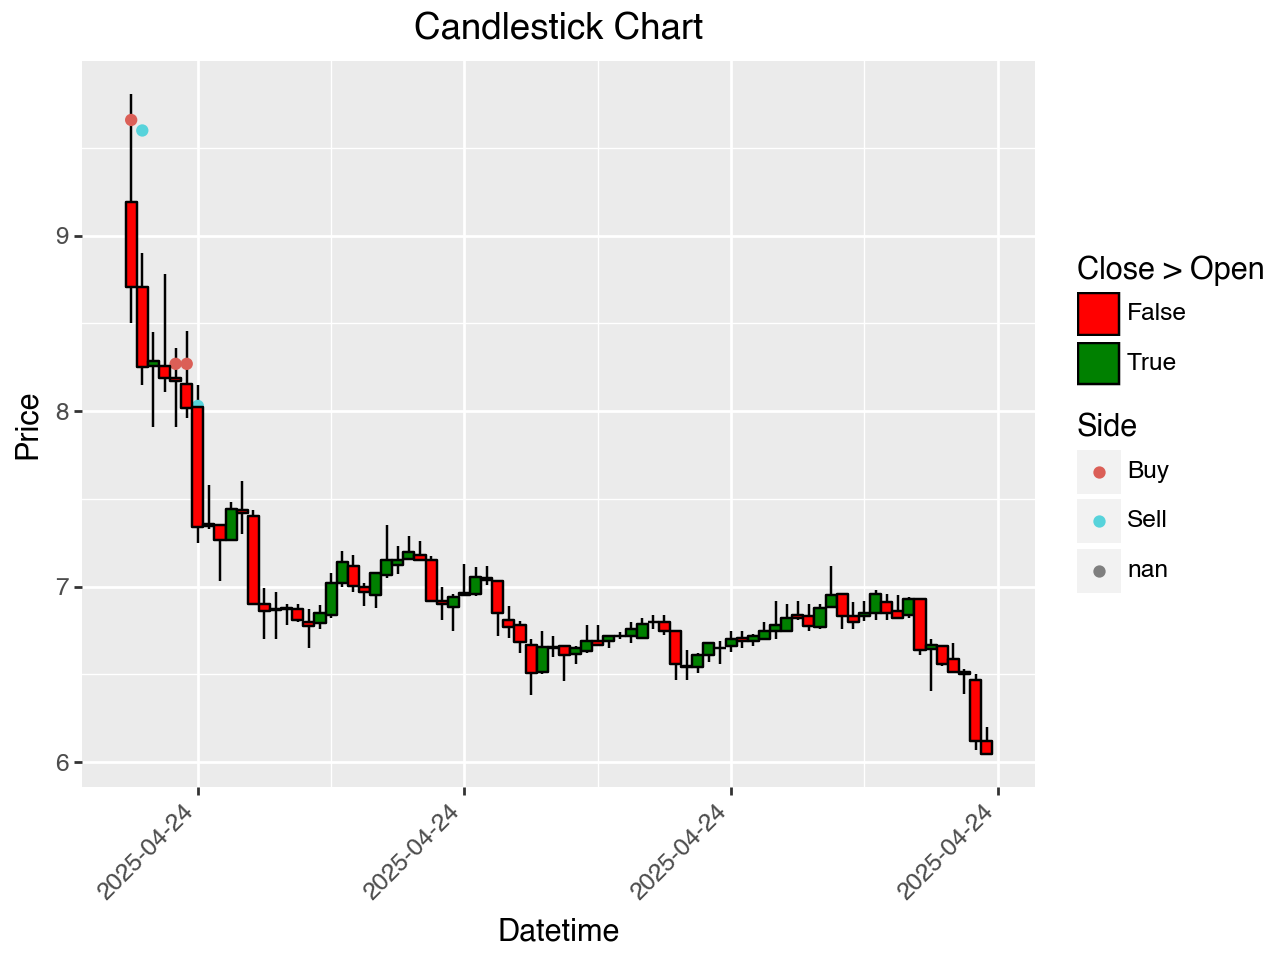

In [114]:
candlestick_plot = (
        p9.ggplot(stock_order_df, p9.aes(x='Datetime')) +
        p9.geom_segment(p9.aes(x='Datetime', xend='Datetime', y='Low', yend='High'), color='black') +
        p9.geom_point(p9.aes(x='Datetime', y='Avg Price',color="Side"))+
        p9.geom_rect(
            p9.aes(
                xmin='Datetime - pd.Timedelta(minutes=2.5)', 
                xmax='Datetime + pd.Timedelta(minutes=2.5)', 
                ymin='Open', 
                ymax='Close', 
                fill='Close > Open'
            ),
            color='black'
        ) +
        p9.scale_fill_manual(values={True: 'green', False: 'red'}) +
        p9.labs(title="Candlestick Chart", x="Datetime", y="Price") +
        p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
)
candlestick_plot